In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs entire domain
w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# generate grid points
def generate_grid_samples(x_min, x_max, t_min, t_max, N_x, N_t):
    x = tf.linspace(x_min, x_max, N_x)
    t = tf.linspace(t_min, t_max, N_t)
    X, T = tf.meshgrid(x, t)
    x_flat = tf.reshape(X, [-1, 1])
    t_flat = tf.reshape(T, [-1, 1])
    return x_flat, t_flat

# scale inputs
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# initial condition
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_xt, N_b, N_i, N_grid = 80, 900, 1000, 225

# curriculum training
# w_int = tf.constant(1.0, dtype=DTYPE)
w_cmin, w_cmax = tf.constant(0.98, dtype=DTYPE), tf.constant(1.02, dtype=DTYPE)
t_cmin, t_cmax = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# interior points
w_choice = tf.constant(1.0, dtype=DTYPE)
x_f, t_f = generate_grid_samples(x_min, x_max, t_cmin, t_cmax, N_xt, N_xt)
w_var = tf.random.uniform((int(N_xt*N_xt*0.8), 1), w_cmin, w_cmax, dtype=DTYPE)
w_fixed = tf.ones((int(N_xt*N_xt*0.2), 1), dtype=DTYPE) * w_choice
w_f = tf.concat([w_var, w_fixed], axis=0)
# w_f = tf.linspace(w_cmin, w_cmax, N_xt*N_xt)[:, None]
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled
w_fs = scale_inputs(w_f, w_min, w_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.linspace(t_cmin, t_cmax, N_b//2)[:, None]
t_b = tf.tile(t_b, [2, 1])
w_var = tf.random.uniform((int(N_b*0.8), 1), w_cmin, w_cmax, dtype=DTYPE)
w_fixed = tf.ones((int(N_b*0.2), 1), dtype=DTYPE) * w_choice
w_b = tf.concat([w_var, w_fixed], axis=0)
# w_b = tf.ones_like(x_b) * w_int
# w_b = tf.linspace(w_cmin, w_cmax, N_b//2)[:, None]
# w_b = tf.tile(w_b, [2, 1])
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled
w_bs = scale_inputs(w_b, w_min, w_max)  # scaled

# initial points
x_i = tf.linspace(x_min, x_max, N_i)[:, None]
t_i = tf.zeros_like(x_i, dtype=DTYPE)
w_var = tf.random.uniform((int(N_i*0.8), 1), w_cmin, w_cmax, dtype=DTYPE)
w_fixed = tf.ones((int(N_i*0.2), 1), dtype=DTYPE) * w_choice
w_i = tf.concat([w_var, w_fixed], axis=0)
# w_i = tf.ones_like(x_i) * w_int
# w_i = tf.linspace(w_cmin, w_cmax, N_i)[:, None]
x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled
w_is = scale_inputs(w_i, w_min, w_max)  # scaled

psi_i = tf.cast(psi_init(x_i, w_i, pi), tf.complex128)

# grid for normalization penalty
x_n = tf.linspace(x_min, x_max, N_grid)[:, None]
x_ns = scale_inputs(x_n, x_min, x_max)

In [10]:
# check shapes and data types
print('x_i')
print(tf.shape(x_is))
print(x_is.dtype)
print(tf.shape(t_is))
print(t_is.dtype)
print(tf.shape(w_is))
print(w_is.dtype)
print(tf.shape(psi_i))
print(psi_i.dtype, '\n')

print('x_b')
print(tf.shape(x_bs))
print(x_bs.dtype)
print(tf.shape(t_bs))
print(t_bs.dtype)
print(tf.shape(w_bs))
print(w_bs.dtype, '\n')

print('x_f')
print(tf.shape(x_fs))
print(x_fs.dtype)
print(tf.shape(t_fs))
print(t_fs.dtype)
print(tf.shape(w_fs))
print(w_fs.dtype, '\n')

print('x_n')
print(tf.shape(x_ns))
print(x_ns.dtype)

x_i
tf.Tensor([1000    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([1000    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([1000    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([1000    1], shape=(2,), dtype=int32)
<dtype: 'complex128'> 

x_b
tf.Tensor([900   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([900   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([900   1], shape=(2,), dtype=int32)
<dtype: 'float64'> 

x_f
tf.Tensor([6400    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([6400    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([6400    1], shape=(2,), dtype=int32)
<dtype: 'float64'> 

x_n
tf.Tensor([225   1], shape=(2,), dtype=int32)
<dtype: 'float64'>


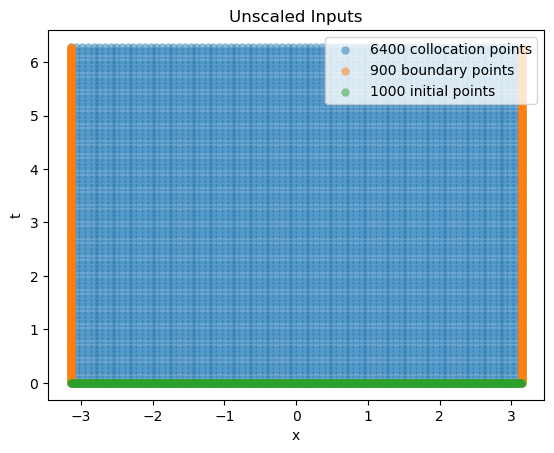

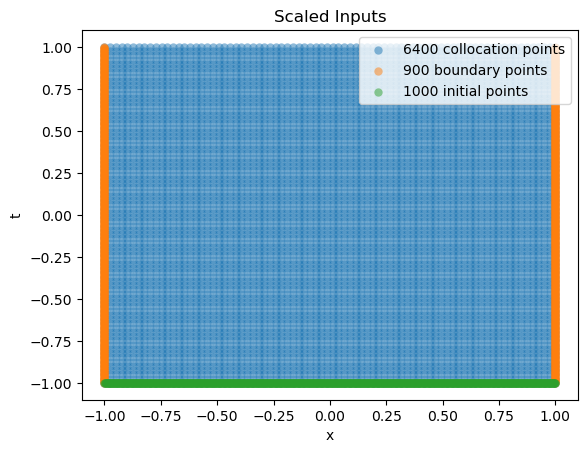

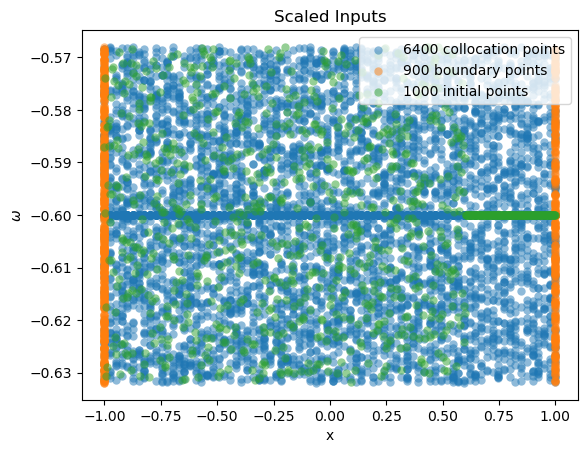

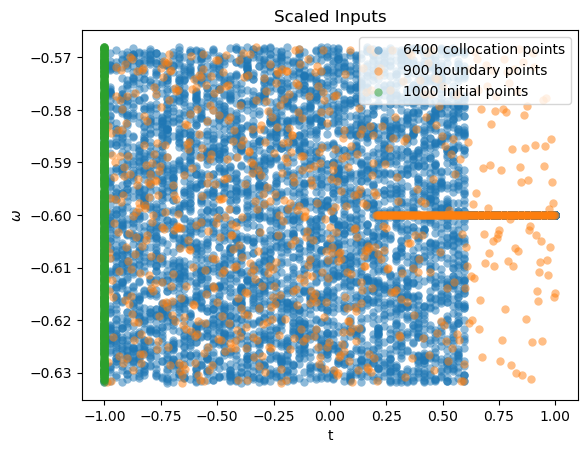

In [11]:
# plot data points

# plotting collocation, boundary, and initial points
plt.scatter(x_f, t_f, alpha=0.5, linewidths=1e-6, label=f'{N_xt*N_xt} collocation points')
plt.scatter(x_b, t_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_i, t_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Unscaled Inputs')
plt.legend(loc='upper right')
plt.show()

plt.scatter(x_fs, t_fs, alpha=0.5, linewidths=1e-6, label=f'{N_xt*N_xt} collocation points')
plt.scatter(x_bs, t_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_is, t_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

plt.scatter(x_fs, w_fs, alpha=0.5, linewidths=1e-6, label=f'{N_xt*N_xt} collocation points')
plt.scatter(x_bs, w_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_is, w_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('$\omega$')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

plt.scatter(t_fs, w_fs, alpha=0.5, linewidths=1e-6, label=f'{N_xt*N_xt} collocation points')
plt.scatter(t_bs, w_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(t_is, w_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('t')
plt.ylabel('$\omega$')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
w_test, w_tests = t_f, t_fs

print(w_test[-1], '\n')
print(w_tests[0:5])
print(tf.shape(w_test), tf.shape(w_tests))
print(w_test.dtype, w_tests.dtype)

In [4]:
# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=3, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense5 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense6 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t, w):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            xs = scale_inputs(x, x_min, x_max)
            ts = scale_inputs(t, t_min, t_max)
            ws = scale_inputs(w, w_min, w_max)
            X = tf.concat([xs, ts, ws], axis=1)
            # uv = tf.clip_by_value(model(X), -1e2, 1e2) # prevent extreme values
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x) #, unconnected_gradients='zero')
        v_x = tape1.gradient(v, x) #, unconnected_gradients='zero')
        u_t = tape1.gradient(u, t) #, unconnected_gradients='zero')
        v_t = tape1.gradient(v, t) #, unconnected_gradients='zero')
    u_xx = tape2.gradient(u_x, x) #, unconnected_gradients='zero')
    v_xx = tape2.gradient(v_x, x) #, unconnected_gradients='zero')
    del tape1, tape2

    potential = 0.5 * w**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def norm_loss(model, x_ns, N_t):
    t_n = tf.random.uniform((N_t, 1), t_cmin, t_cmax, dtype=DTYPE)
    t_ns = scale_inputs(t_n, t_min, t_max)
    w_rand = tf.random.uniform((), w_cmin, w_cmax, dtype=DTYPE)
    w_n = tf.ones_like(x_ns) * w_rand
    w_ns = scale_inputs(w_n, w_min, w_max)
    norm_penalty_total = 0.0
    for t_val in tf.unstack(t_ns, axis=0):
        t_in = tf.ones_like(x_ns) * t_val
        X = tf.concat([x_ns, t_in, w_ns], axis=1)
        uv = model(X)
        dx = (x_max - x_min) / tf.cast(tf.shape(x_ns)[0], dtype=DTYPE)
        norm = tf.reduce_sum(tf.math.abs(uv)**2) * dx
        norm_penalty_total += tf.square(norm - 1.0)
    norm_penalty = norm_penalty_total / tf.cast(N_t, dtype=DTYPE)

    return norm_penalty

@tf.function
def loss_fn(model, interior, boundary, initial, norm_grid, omega):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    x_grid, N_t = norm_grid
    w_f, w_b, w_i = omega

    f_u, f_v = pde_residual(model, x_f, t_f, w_f)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v)) # / tf.cast(tf.shape(x_f)[0], dtype=DTYPE)

    uv_b = model(tf.concat([x_b, t_b, w_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b[:, 0:1]) + tf.square(uv_b[:, 1:2])) # / tf.cast(tf.shape(x_b)[0], dtype=DTYPE)

    uv_i = model(tf.concat([x_i, t_i, w_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i))) # / tf.cast(tf.shape(x_i)[0], dtype=DTYPE)
    
    norm_penalty = norm_loss(model, x_grid, N_t)
    
    return loss_f + loss_b + loss_i + norm_penalty, (loss_f, loss_b, loss_i, norm_penalty)

In [5]:
# Define the Optimizer
# Learning rate schedule with exponential decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True
)

# ADAM optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(model, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, x_n, N_t, w_f, w_b, w_i):
    with tf.GradientTape() as tape:
        loss, (lf, lb, li, ln) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i), (x_n, N_t), (w_f, w_b, w_i))
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (lf, lb, li, ln)

In [ ]:
# # Instantiate the Model
# pinn = PINN(input_dim=3, mapping_size=512, scale=10.0)

pinn = tf.keras.models.load_model('best_model_v2p4.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

pinn.dense1.trainable = False
pinn.dense2.trainable = False

for layer in pinn.layers:
    print(f"{layer.name}: trainable = {layer.trainable}")


Model loaded successfully
Epoch 0: Loss = 3.22881e-03 (f = 3.100e-03, b = 9.714e-06, i = 1.629e-05, n = 1.028e-04)


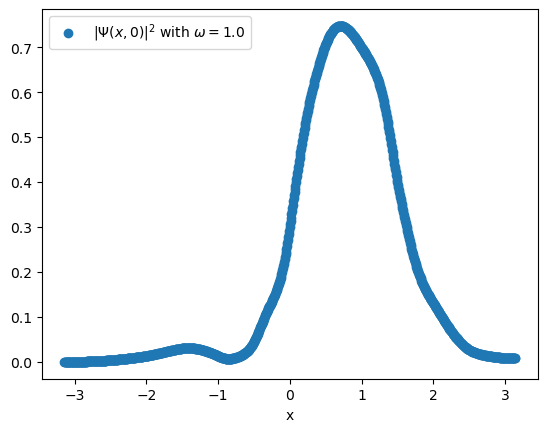

Best model saved to best_model_v3p1.keras at epoch 0 with loss 0.00322880619475176
Best model saved to best_model_v3p1.keras at epoch 57 with loss 0.002659929496641608
Best model saved to best_model_v3p1.keras at epoch 64 with loss 0.002524936120593607
Best model saved to best_model_v3p1.keras at epoch 72 with loss 0.0022771367896274215
Best model saved to best_model_v3p1.keras at epoch 82 with loss 0.002005236481603601
Best model saved to best_model_v3p1.keras at epoch 96 with loss 0.0019438733456885794
Best model saved to best_model_v3p1.keras at epoch 97 with loss 0.0017795387248658728
Best model saved to best_model_v3p1.keras at epoch 98 with loss 0.0016900056358120717
Best model saved to best_model_v3p1.keras at epoch 99 with loss 0.0016300352246671013
Best model saved to best_model_v3p1.keras at epoch 100 with loss 0.0016015415872188143
Best model saved to best_model_v3p1.keras at epoch 101 with loss 0.0013775586919451337
Best model saved to best_model_v3p1.keras at epoch 102 wit

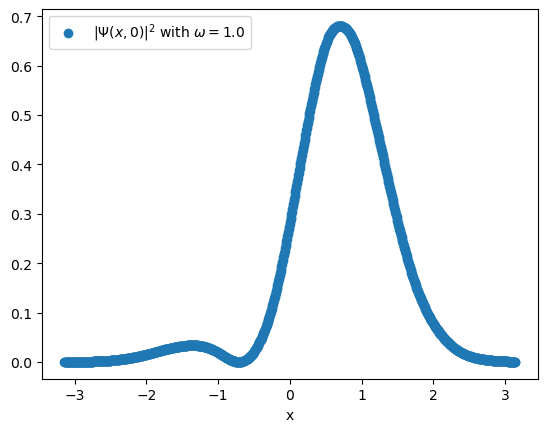

In [ ]:
# Define the loss threshold
loss_threshold = 1e-10

# Early stopping
early_stopping_patience = 500
best_loss = float('inf')
patience_counter = 0

# saving loss values
train_loss_results = {
    "total": [],
    "pde": [],
    "boundary": [],
    "initial": [],
    "norm" : []
}

# Start the timer
start_time = time.time()

best_model_path = "best_model_v6p1.keras"

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss, (lf, lb, li, ln) = train_step(pinn, x_f, t_f, x_bs, t_bs, x_is, t_is, psi_i, x_ns, 20, w_f, w_bs, w_is)

    train_loss_results["total"].append(loss.numpy())
    train_loss_results["pde"].append(lf.numpy())
    train_loss_results["boundary"].append(lb.numpy())
    train_loss_results["initial"].append(li.numpy())
    train_loss_results["norm"].append(ln.numpy())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy().item():.5e} (f = {lf.numpy().item():.3e}, b = {lb.numpy().item():.3e}, i = {li.numpy().item():.3e}, n = {ln.numpy().item():.3e})")
        w_choice = 1.0
        w_test = tf.ones_like(x_is) * w_choice
        w_in = scale_inputs(w_test, w_min, w_max)
        X = tf.concat([x_is, t_is, w_in], axis=1)
        uv = pinn(X)
        u, v = uv[:, 0:1], uv[:, 1:2]
        density = u**2 + v**2

        plt.scatter(x_i, density, label=f'$|\Psi(x,0)|^2$ with $\omega={w_choice}$')
        plt.xlabel('x')
        plt.legend()
        plt.show()
        
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        patience_counter = 0
        pinn.save(best_model_path)
        print(f"Best model saved to {best_model_path} at epoch {epoch} with loss {loss.numpy()}")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss.numpy()}")
        break
    
    if loss.numpy() < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss.numpy()}")
        break

    epoch += 1

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(train_loss_results["total"], label="Total Loss")
plt.plot(train_loss_results["pde"], label="PDE Loss")
plt.plot(train_loss_results["boundary"], label="Boundary Loss")
plt.plot(train_loss_results["initial"], label="Initial Loss")
plt.plot(train_loss_results["norm"], label="Norm Loss")
plt.yscale("log")
plt.legend()
plt.title("Loss Components During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()

# pinn.save('last_trained_v2p0.keras')
# print(f"last model saved")

# Save to CSV
with open("train_loss_results_v6p1.csv", "w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["epoch", "total_loss", "pde_loss", "boundary_loss", "initial_loss", "norm_loss"])
    
    # Write data row by row
    for epoch, (total, pde, boundary, initial, norm) in enumerate(zip(
        train_loss_results["total"],
        train_loss_results["pde"],
        train_loss_results["boundary"],
        train_loss_results["initial"],
        train_loss_results["norm"]
    )):
        writer.writerow([epoch, total, pde, boundary, initial, norm])


# # Save original weights
# original_weights = pinn.get_weights()

# # Load the model
# loaded_pinn = tf.keras.models.load_model(best_model_path, custom_objects={'PINN': PINN})

# # Check if the weights match
# loaded_weights = loaded_pinn.get_weights()

# for orig, loaded in zip(original_weights, loaded_weights):
#     if not np.array_equal(orig, loaded):
#         print("Weights do not match after loading!")
#     else:
#         print("Weights match.")